In [92]:
import pandas as pd
import re
from pygeocoder import Geocoder
from scipy import stats
import pylab
from sklearn import tree
from io import StringIO
import pydotplus
from IPython.display import Image
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
user_df = pd.read_csv("user_table.csv")
user_df.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [94]:
test_df = pd.read_csv("test_results.csv")
test_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [95]:
df = test_df.merge(user_df, how='left', on='user_id')
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [96]:
df[(df['test']==1)&(df['price']==39)].shape

(155, 12)

There are 155 users who are supposed to be in the test group but are given a \$39 item.

In [99]:
df[(df['test']==0)&(df['price']==59)].shape

(0, 12)

There are 210 users who are supposed to be in the control group but are given a \$59 item.

In [98]:
df.drop(df[(df['test']==1)&(df['price']==39)].index,inplace=True)
df.drop(df[(df['test']==0)&(df['price']==59)].index,inplace=True)

Drop the inconsistent user/price, but this doesn't appear to change any of the results.

In [100]:
df['timestamp'] = df['timestamp'].apply(lambda x: re.sub('60', '00', x)) 
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [101]:
df['date'] = df['timestamp'].dt.date

In [102]:
data_test = df[df['test']==1]
data_control = df[df['test']==0]

/home/rebecca/anaconda3/envs/my_projects_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/rebecca/anaconda3/envs/my_projects_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/rebecca/anaconda3/envs/my_projects_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


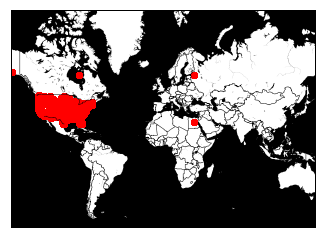

In [48]:
from mpl_toolkits.basemap import Basemap
import string
import matplotlib.cm as cm
#m = Basemap(projection='ortho',lon_0=-50,lat_0=60,resolution='l')
m = Basemap(llcrnrlon=-150.,llcrnrlat=-60.,urcrnrlon=150.,urcrnrlat=80.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=20.,lon_0=-20.,lat_ts=20.)
x1,y1=m(df['long'].values,df['lat'].values)
m.drawmapboundary(fill_color='black') # fill to edge
m.drawcountries()
m.fillcontinents(color='white',lake_color='black',zorder=0)
m.scatter(x1,y1,marker="o",c='red',cmap=cm.cool,alpha=0.7)
plt.title("")
plt.show()

In [180]:
cities = []
states = []
import time
for i in range(df.shape[0]):

    time.sleep(2)
    results = Geocoder.reverse_geocode(df['lat'][0], df['long'][0])
    if(results.country == 'United States'):
        results.country = "USA"
    if(results.country != df['country'][0]):
        print("{} {}".format(results.country,df['country'][0]))
        cities.append(results.city)
        states.append(states.city)

GeocoderError: Error OVER_QUERY_LIMIT
Query: https://maps.google.com/maps/api/geocode/json?latlng=42.890000%2C-78.860000&sensor=false&bounds=&region=&language=

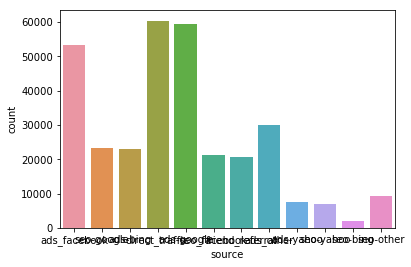

In [145]:
sns.countplot(data=df,x='source')
plt.show()

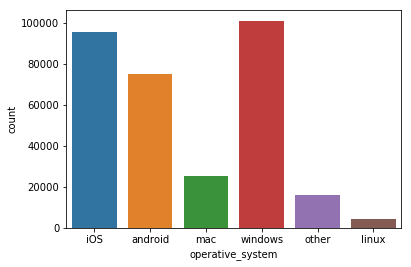

In [146]:
sns.countplot(data=df,x='operative_system')
plt.show()

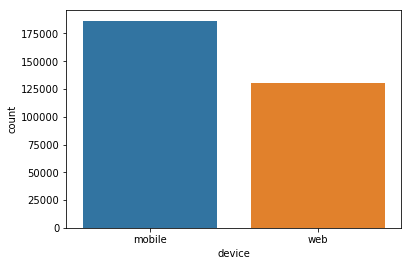

In [143]:
sns.countplot(data=df,x='device')
plt.show()

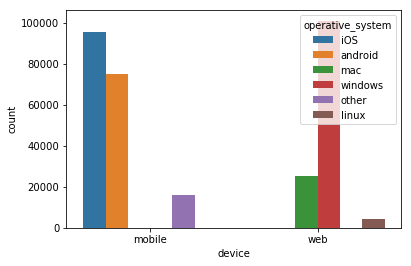

In [147]:
sns.countplot(data=df,x='device',hue='operative_system')
plt.show()

In [103]:
data_test = df[df['test']==1]
data_control = df[df['test']==0]

## T-test between conversion rates of test and control

In [67]:
print(stats.ttest_ind(data_test['converted'], data_control['converted']))
print(data_test['converted'].mean())
print(data_control['converted'].mean())

Ttest_indResult(statistic=-8.744781828681587, pvalue=2.2450851601497147e-18)
0.0155550483681
0.0198995639872


#### T-test results

I perform a t-test to determine whether there is any difference in conversion proportions for the two groups. The two groups are 'control', those who have the \$39 software, and 'test', those who have the $59 software.
The p-value for the t-test is extremely small, implying that there is indeed a difference. The proportion of the control group that converted is 1.99%, while the proportion of the test group that converted is 1.55%. This is a 21% drop in conversions (1.99-1.55)/1.99=21%.

#### T-test reflection

Are the results of the t-test convincing? It seems questionable that the p-value is basically zero. Some things to investigate are whether enough data is collected and whether people are indeed assigned randomly to the control and test groups.

#### P-value vs time

In [137]:
pd.to_datetime(data_test['date'],unit='D')
pd.to_datetime(data_control['date'],unit='D')

0        2015-05-08
1        2015-05-10
2        2015-04-04
4        2015-05-24
5        2015-04-13
6        2015-03-04
10       2015-04-17
11       2015-05-15
12       2015-04-24
13       2015-03-21
14       2015-05-29
16       2015-03-16
17       2015-03-08
19       2015-03-04
20       2015-04-04
21       2015-05-03
22       2015-05-31
23       2015-05-16
26       2015-04-25
30       2015-05-23
31       2015-04-17
32       2015-05-01
34       2015-05-01
37       2015-03-20
39       2015-04-02
40       2015-03-31
43       2015-04-05
44       2015-04-15
48       2015-03-07
49       2015-04-04
            ...    
316759   2015-04-28
316760   2015-04-06
316761   2015-03-13
316763   2015-04-09
316764   2015-04-23
316766   2015-04-18
316767   2015-05-22
316768   2015-05-16
316769   2015-03-31
316771   2015-05-23
316773   2015-05-19
316774   2015-04-17
316779   2015-04-06
316780   2015-05-31
316781   2015-04-12
316783   2015-03-15
316784   2015-03-06
316785   2015-03-13
316786   2015-03-07


In [162]:
pvals = []
for i in pd.date_range(min(data_test['date']),max(data_test['date'])):
    slice1 = data_test[data_test['date']<=i]['converted']
    slice2 = data_control[data_control['date']<=i]['converted']
    pvals.append(stats.ttest_ind(slice1,slice2)[1])

In [172]:
np.where(np.array(pvals)<0.001)[0][0]

24

In [173]:
date_range = pd.date_range(min(data_test['date']),max(data_test['date']))
date_range[24]

Timestamp('2015-03-26 00:00:00', freq='D')

This is the day on which the p-value becomes less than the critical value (0.001), which is roughly 3 weeks. So the company could stop collecting data after this point, but I think they should decide ahead of time how long the trial should run for.

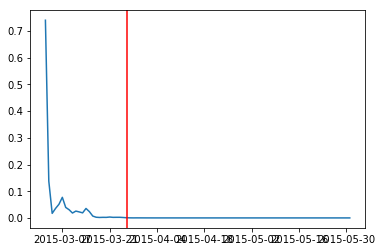

In [177]:
plt.plot(date_range,pvals)
plt.axvline(x='2015-03-26 00:00:00',color='red')

## Conversion rates vs time

/home/rebecca/anaconda3/envs/my_projects_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


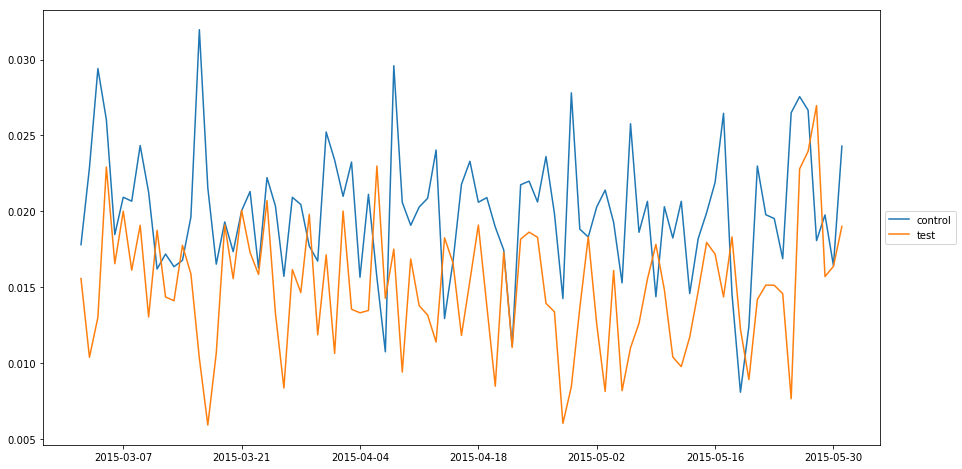

In [179]:
df['control'] = df['test'].apply(lambda x: 1 if x==0 else 0 )
df1 = data_test[['converted','date']]
mean = df1.groupby('date').mean()
df2 = data_control[['converted','date']]
mean1 = df2.groupby('date').mean()
fg = plt.figure(figsize=(15, 8))
pylab.legend(loc='center left', bbox_to_anchor=(1, 0.5))
pylab.plot(mean1['converted'],label="control")
pylab.plot(mean['converted'],label="test")
pylab.legend(loc='center left', bbox_to_anchor=(1, 0.5))

The conversion rate vs time plot shows us that the test group is usually less than the control group.
However, towards the end of the study, the test group rate becomes suspiciously as large/larger than the control rate. The length of the test can probably be shortened because the conversion rate is always lower for the test group.

## Test randomization

In [30]:
df['day_of_year'] = df['date'].apply(lambda x: x.timetuple().tm_yday)

In [53]:
dummy = pd.get_dummies(df[['source','device', 'operative_system']])
concat_df = pd.concat([dummy, df], axis=1)
df_for_tree = concat_df[['test','control','day_of_year','converted']]

clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(df_for_tree[['test','day_of_year']], df_for_tree['converted'])

tree.export_graphviz(clf,out_file='tree.dot')

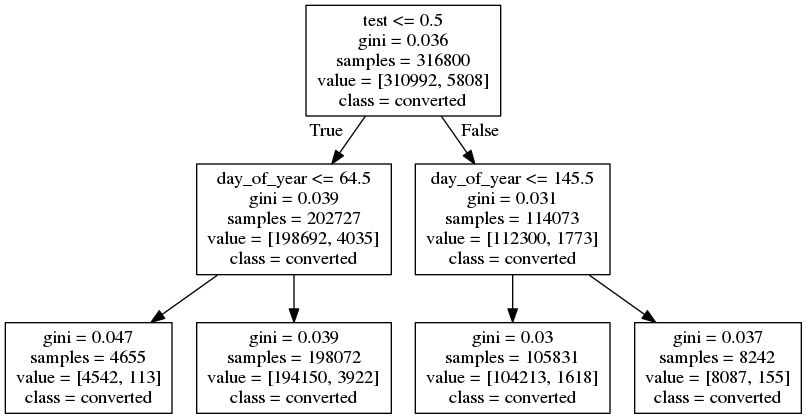

In [54]:
out = StringIO()
tree.export_graphviz(clf, out_file = out,feature_names=['test','day_of_year'],  
                         class_names=['converted'])
 
graph=pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())

The 64.5th day of year corresponds to March 5, 2015. The tree shows that the conversion rate for the control group is 113/4655=2.4%, and then it decreases to 3922/198072=2%. 

The 145.5th day of the year corresponds to May 25, 2015. The tree shows that the conversion rate for the test group is 1618/105831=1.5% before that day, and then increases to 155/8242=1.9%. This confirms what we saw in the time series plot. For some reason, people in the test group are purchasing the \$59 during the last week of the test.

In [33]:
data_test_nona = data_test.dropna()
data_control_nona = data_control.dropna()
cities = data_test_nona['city'].unique()
output, n_test, n_control, stat, nconverts_control, nconverts_test = [], [], [], [], [], []


for city in cities:
    data_test_nona_bycity = data_test_nona[data_test_nona['city']==city]
    data_control_nona_bycity = data_control_nona[data_control_nona['city']==city]
    output.append(stats.ttest_ind(data_test_nona_bycity['converted'], data_control_nona_bycity['converted']).pvalue)
    nconverts_test.append(data_test_nona_bycity['converted'].mean())
    nconverts_control.append(data_control_nona_bycity['converted'].mean())
    n_test.append(len(data_test_nona_bycity))
    n_control.append(len(data_control_nona_bycity))
    stat.append(stats.ttest_ind(data_test_nona_bycity['converted'], data_control_nona_bycity['converted']).statistic)
    
final_df = pd.DataFrame({'city':cities, 'p_value':output, 'test_statistic':stat,'nconverts_test':nconverts_test,\
                         'nconverts_control':nconverts_control,'n_test':n_test,'n_control':n_control})

/home/rebecca/anaconda3/envs/my_projects_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/rebecca/anaconda3/envs/my_projects_env/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
len(np.where(final_df['p_value']<0.05)[0])

26

In [35]:
final_df[(final_df['p_value']<0.05) & (final_df['test_statistic']<0)].shape

(16, 7)

26 cities out of 988 cities have a difference in conversion rate, and 16 of them have a lower conversion for test. There isn't any statistical difference for 97% of the cities, so this implies that the company should sell the \$59 software. The cities that saw a statistical difference had 13\% of the users. However, note that this doesn't include users who didn't have city information.

In [40]:
df_for_tree = concat_df.drop(['user_id','timestamp','converted','source',\
       'device', 'operative_system','price', 'city',
       'country', 'lat', 'long', 'date', 'control'],axis=1)
target = concat_df['converted']

In [42]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(df_for_tree,target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

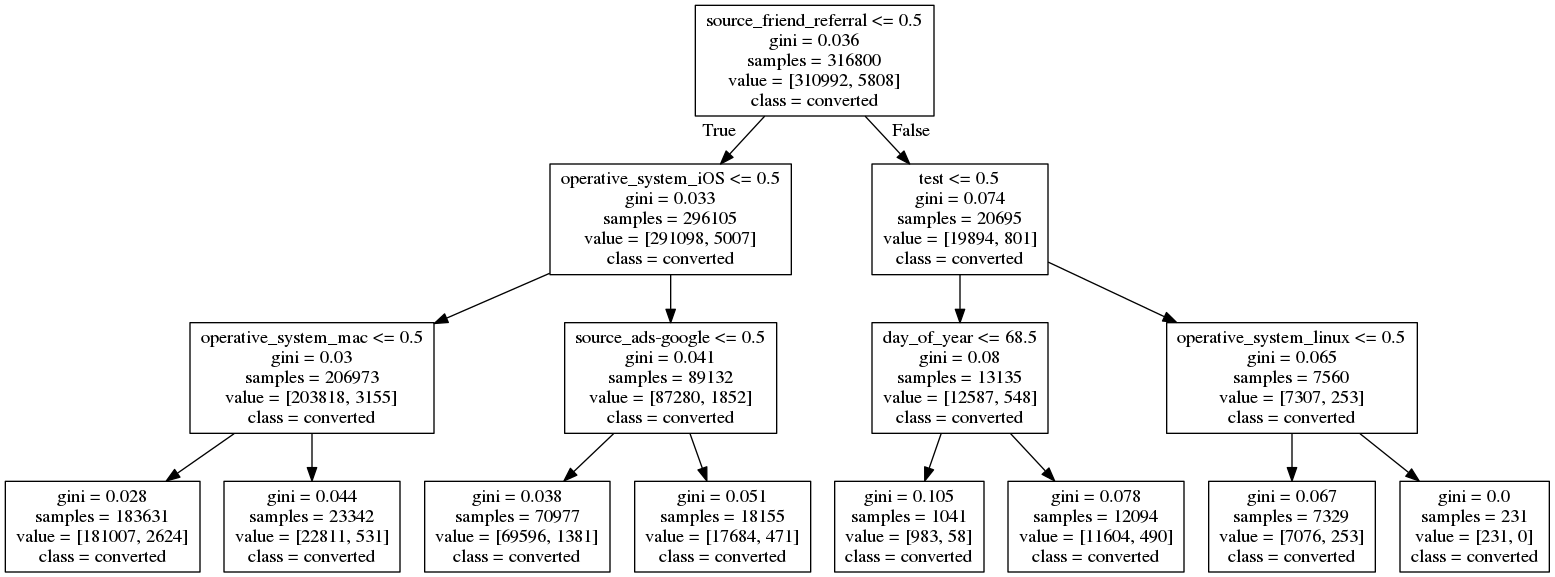

In [46]:
tree.export_graphviz(clf,out_file='tree.dot')

out = StringIO()
tree.export_graphviz(clf, out_file = out,feature_names=list(df_for_tree.columns.values),  
                         class_names=['converted'])
 
graph=pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())

This shows us that if someone was referred by their friend, the conversion rate is 4%, otherwise it is 1.7%. If the operating system isn't iOS, the conversion rate is 1.5%, otherwise, the conversion rate is 2.1%. Furthermore, the conversion rate is higher for iOS users using Google. Additionally, the conversion rate is higher for users with Mac computers. For users in the test group who are referred by friends, if they are using linux, there aren't any conversions.

The company can give referal bonuses since referals increase conversions. It can also try to bring the conversion rate for all groups to the same percentage (i.e. bring Android up to iOS rate, Bing etc. to Google rate).

Todo: permutation test, power